#**Aprendizaje Automático** - 2023
# Clase 12: El tallercito de redes neuronales

*Trabajaron en esta notebook: Sofia Del Pozo, Diego Onna, Gastón Bujía*

## Contenidos

* Cargar imagenes

* Clasificación de imagenes con una red

# Datos: MNIST

In [1]:
import os
from urllib import request
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.utils import np_utils 

## Descarga y creación de carpetas: La manera difícil

In [2]:
# Definir las URL de los archivos de datos
base_url = 'http://yann.lecun.com/exdb/mnist/'
file_names = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
              't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

# Crear las carpetas necesarias
main_folder = 'mnist'
train_folder = 'mnist/train/'
test_folder = 'mnist/test/'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Descargar los archivos de datos
for file_name in file_names:
    url = base_url + file_name
    file_path = os.path.join(main_folder, file_name)
    request.urlretrieve(url, file_path)
    print(f'{file_name} descargado')

train-images-idx3-ubyte.gz descargado
train-labels-idx1-ubyte.gz descargado
t10k-images-idx3-ubyte.gz descargado
t10k-labels-idx1-ubyte.gz descargado


In [4]:
# Descomprimir los archivos de datos
with gzip.open(os.path.join(main_folder, 'train-images-idx3-ubyte.gz'), 'rb') as f:
    train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(os.path.join(main_folder, 'train-labels-idx1-ubyte.gz'), 'rb') as f:
    train_labels = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open(os.path.join(main_folder, 't10k-images-idx3-ubyte.gz'), 'rb') as f:
    test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(os.path.join(main_folder, 't10k-labels-idx1-ubyte.gz'), 'rb') as f:
    test_labels = np.frombuffer(f.read(), np.uint8, offset=8)

print('El conjunto de datos MNIST se descomprimió correctamente.')

El conjunto de datos MNIST se descomprimió correctamente.


Que quedo guardado en cada variable?

In [5]:
train_images.shape, test_images.shape 

((60000, 28, 28), (10000, 28, 28))

Veamos como se ve una de las imagenes

In [6]:
train_images[0].shape

(28, 28)

Veamos su correspondiente etiqueta

In [7]:
train_labels[0]

5

Text(0.5, 1.0, 'Class 5')

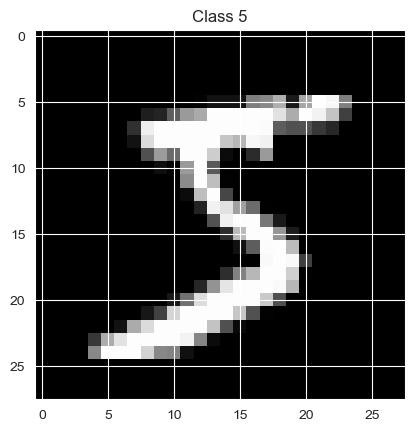

In [8]:
plt.imshow(train_images[0], cmap='gray', interpolation='none')
plt.title("Class {}".format(train_labels[0]))

In [9]:
# Guardar las imágenes en las carpetas correspondientes
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    folder_path = os.path.join(train_folder, str(label))
    os.makedirs(folder_path, exist_ok=True)
    image_path = os.path.join(folder_path, f'{i}.png')
    Image.fromarray(image).save(image_path)

for i, (image, label) in enumerate(zip(test_images, test_labels)):
    folder_path = os.path.join(test_folder, str(label))
    os.makedirs(folder_path, exist_ok=True)
    image_path = os.path.join(folder_path, f'{i}.png')
    Image.fromarray(image).save(image_path)

print('El conjunto de datos MNIST se ha descargado y organizado correctamente.')

El conjunto de datos MNIST se ha descargado y organizado correctamente.


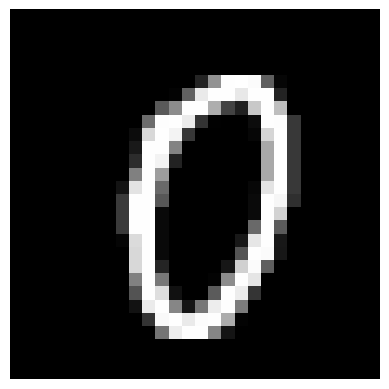

In [ ]:
# Leer una imagen de muestra desde el disco y mostrarla
sample_image_path = os.path.join(train_folder, '0', '1000.png')
sample_image = plt.imread(sample_image_path)

plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.show()

La manera fácil: 



```
from keras.datasets import mnist
mnist.load_data()
```



## Hagamos una red neuronal multicapa

Primero tenemos que entender de que tamaño son los conjuntos y las imagenes.

In [ ]:
train_images.shape

(60000, 28, 28)

In [11]:
print("El número de ejemplos en el conjunto de entrenamiento:", train_images.shape[0], "y el tamaño de cada imagen es (%d, %d)"%(train_images.shape[1], train_images.shape[2]))
print("El número de ejemplos en el conjunto de testeo:", test_images.shape[0], "y el tamaño de cada imagen es (%d, %d)"%(test_images.shape[1], test_images.shape[2]))

El número de ejemplos en el conjunto de entrenamiento: 60000 y el tamaño de cada imagen es (28, 28)
El número de ejemplos en el conjunto de testeo: 10000 y el tamaño de cada imagen es (28, 28)


La forma de entrada es un vector bidimensional. Para cada imagen, tenemos un vector de dimensiones (28x28) y lo convertiremos el vector de dimensiones (28x28) en un vector unidimensional de 1x784.

In [13]:
train_images.shape[1]

28

In [14]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2]) 
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2]) 

In [15]:
print("El númeor de ejemplos en el conjunto de entrenamiento:", train_images.shape[0], "y el tamaño de cada imagen es (%d)"%(train_images.shape[1]))
print("El númeor de ejemplos en el conjunto de testeo:", test_images.shape[0], "y el tamaño de cada imagen es (%d)"%(test_images.shape[1]))

El númeor de ejemplos en el conjunto de entrenamiento: 60000 y el tamaño de cada imagen es (784)
El númeor de ejemplos en el conjunto de testeo: 10000 y el tamaño de cada imagen es (784)


In [17]:
print(train_images[0])

60000


Si observamos la matriz anterior, cada elemento tiene un valor entre 0 y 255. Antes de aplicar la red, intentemos normalizar los datos.

X => (X - Xmin)/(Xmax-Xmin) = X/255

In [18]:
train_images = train_images/255
test_images = test_images/255

In [ ]:
print(train_images[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

Ahora tenemos que enfocarnos en los labels. ¿Cómo son?

In [19]:
print("Class label of first image :", train_labels[0])

Class label of first image : 5


Vamos a convertir esto en un vector de 10 dimensiones. Por ejemplo, si consideramos una imagen que es un 5, lo convertiremos en 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0].
Esta conversión es necesaria para las redes neuronales multicapa (MLPs).

In [20]:
train_labels = np_utils.to_categorical(train_labels, 10) #one hot encoding
test_labels = np_utils.to_categorical(test_labels, 10)#one hot encoding

print("Después de convertir la salida en un vector: ",train_labels[0])

Después de convertir la salida en un vector:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Red neuronal simple capa

Definimos algunos parametros

In [24]:
output_dim = 10
input_dim = train_images.shape[1]

batch_size = 128 
nb_epoch = 20

In [25]:
model = Sequential()
model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid',input_shape=(input_dim,)))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(test_images, test_labels)) 

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 1.2673 - accuracy: 0.6948 - val_loss: 0.8117 - val_accuracy: 0.8354
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.7202 - accuracy: 0.8415 - val_loss: 0.6082 - val_accuracy: 0.8636
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5901 - accuracy: 0.8600 - val_loss: 0.5263 - val_accuracy: 0.8733
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5276 - accuracy: 0.8694 - val_loss: 0.4804 - val_accuracy: 0.8808
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4896 - accuracy: 0.8747 - val_loss: 0.4504 - val_accuracy: 0.8862
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4634 - accuracy: 0.8793 - val_loss: 0.4295 - val_accuracy: 0.8889
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.4441 - accuracy: 0.8826 - val_loss: 0.4129 - val_accuracy: 0.8936
Epoch 

In [27]:
score = model.evaluate(test_images, test_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.33619827032089233
Test accuracy: 0.9075000286102295


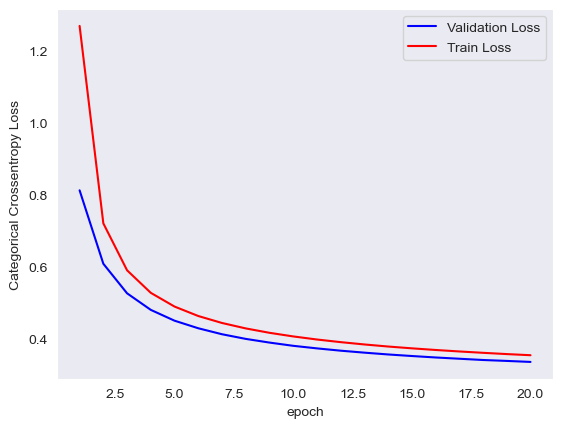

In [28]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

##Red neuronal multicapa

Hagamos una red de 2 capas oculta con 512 nodos en cada capa oculta

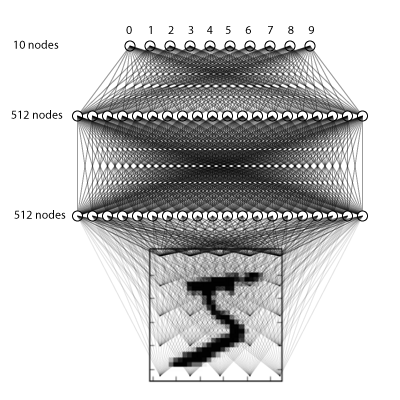

In [31]:
model_multi = Sequential()
model_multi.add(Dense(512, activation='sigmoid', input_shape=(input_dim,)))
model_multi.add(Dense(512, activation='sigmoid'))
model_multi.add(Dense(output_dim, activation='sigmoid'))

model_multi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_multi.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model_multi.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(test_images, test_labels)) 

Epoch 1/20
469/469 [==============================] - 4s 7ms/step - loss: 2.2735 - accuracy: 0.2021 - val_loss: 2.2322 - val_accuracy: 0.4164
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 2.1913 - accuracy: 0.3865 - val_loss: 2.1417 - val_accuracy: 0.4351
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 2.0847 - accuracy: 0.5232 - val_loss: 2.0090 - val_accuracy: 0.5330
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 1.9282 - accuracy: 0.5999 - val_loss: 1.8171 - val_accuracy: 0.6883
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 1.7143 - accuracy: 0.6541 - val_loss: 1.5783 - val_accuracy: 0.7067
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 1.4725 - accuracy: 0.7055 - val_loss: 1.3388 - val_accuracy: 0.7164
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 1.2498 - accuracy: 0.7462 - val_loss: 1.1339 - val_accuracy: 0.7800
Epoch 

In [34]:
score = model_multi.evaluate(test_images, test_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.4446272552013397
Test accuracy: 0.8805000185966492


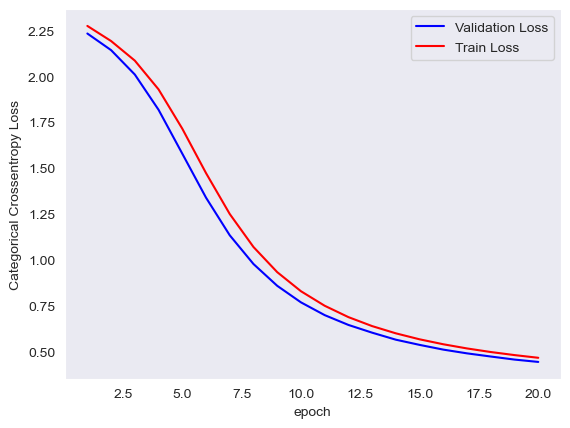

In [35]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

<ipython-input-45-f7194a48b71b>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


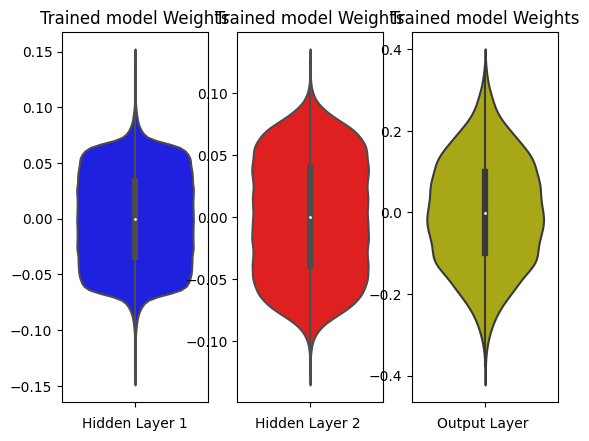

In [ ]:
w_after = model_multi.get_weights()

h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

#Ejercicios

Utilizando el mismo dataset realizar los siguientes ejercicios, luego comparar los resultados y discutir:


## 1. Hacer una nueva Red neuronal multicapa con dos capas ocultas de tamaño 512 y 128.

In [39]:
nueva_red= Sequential()
nueva_red.add(Dense(512, activation= "sigmoid", input_shape= (input_dim,)))
nueva_red.add(Dense(128, activation= "sigmoid"))
nueva_red.add(Dense(output_dim, activation= "sigmoid"))
nueva_red.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])



In [40]:
history = nueva_red.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epoch, validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 2.2705 - accuracy: 0.2151 - val_loss: 2.2243 - val_accuracy: 0.3565
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 2.1797 - accuracy: 0.4618 - val_loss: 2.1232 - val_accuracy: 0.6254
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 2.0618 - accuracy: 0.5903 - val_loss: 1.9792 - val_accuracy: 0.6834
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 1.8942 - accuracy: 0.6488 - val_loss: 1.7800 - val_accuracy: 0.6516
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 1.6758 - accuracy: 0.6811 - val_loss: 1.5425 - val_accuracy: 0.7139
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 1.4401 - accuracy: 0.7207 - val_loss: 1.3115 - val_accuracy: 0.7418
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 1.2294 - accuracy: 0.7540 - val_loss: 1.1214 - val_accuracy: 0.7701
Epoch 

In [44]:
score = nueva_red.evaluate(test_images, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.4575382471084595
Test accuracy: 0.879800021648407


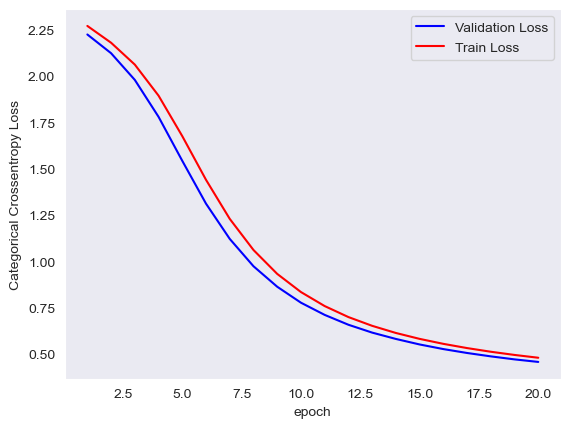

In [42]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

## 2.   Repetir Red neuronal simple capa usando adam como óptimizador


## 3.   Repetir Red neuronal multicapa con dos capas ocultas de tamaño 512 usando adam como óptimizador


In [45]:
nueva_red1= Sequential()
nueva_red1.add(Dense(512, activation= "sigmoid", input_shape= (input_dim,)))
nueva_red1.add(Dense(512, activation= "sigmoid"))
nueva_red1.add(Dense(output_dim, activation= "sigmoid"))
nueva_red1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = nueva_red1.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epoch, validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 6s 10ms/step - loss: 0.4909 - accuracy: 0.8582 - val_loss: 0.2484 - val_accuracy: 0.9279
Epoch 2/20
469/469 [==============================] - 5s 10ms/step - loss: 0.2185 - accuracy: 0.9358 - val_loss: 0.1809 - val_accuracy: 0.9441
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 0.1583 - accuracy: 0.9527 - val_loss: 0.1355 - val_accuracy: 0.9577
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.1210 - accuracy: 0.9638 - val_loss: 0.1135 - val_accuracy: 0.9651
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0925 - accuracy: 0.9725 - val_loss: 0.1011 - val_accuracy: 0.9698
Epoch 6/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0728 - accuracy: 0.9779 - val_loss: 0.0888 - val_accuracy: 0.9723
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0606 - accuracy: 0.9807 - val_loss: 0.0824 - val_accuracy: 0.9753

In [48]:
score = nueva_red1.evaluate(test_images, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0807914137840271
Test accuracy: 0.98089998960495


## 4.   Repetir Red neuronal multicapa con dos capas ocultas de tamaño 512 y 128 usando adam como óptimizador


In [52]:
nueva_red2= Sequential()
nueva_red2.add(Dense(512, activation= "sigmoid", input_shape= (input_dim,)))
nueva_red2.add(Dense(128, activation= "sigmoid"))
nueva_red2.add(Dense(output_dim, activation= "sigmoid"))
nueva_red2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history = nueva_red2.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epoch, validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.5360 - accuracy: 0.8591 - val_loss: 0.2520 - val_accuracy: 0.9274
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2207 - accuracy: 0.9358 - val_loss: 0.1882 - val_accuracy: 0.9425
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1629 - accuracy: 0.9519 - val_loss: 0.1436 - val_accuracy: 0.9574
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1252 - accuracy: 0.9627 - val_loss: 0.1175 - val_accuracy: 0.9648
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0977 - accuracy: 0.9713 - val_loss: 0.1031 - val_accuracy: 0.9684
Epoch 6/20
469/469 [==============================] - 4s 7ms/step - loss: 0.0789 - accuracy: 0.9768 - val_loss: 0.0906 - val_accuracy: 0.9711
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0627 - accuracy: 0.9819 - val_loss: 0.0921 - val_accuracy: 0.9718
Epoch 

In [54]:
score = nueva_red2.evaluate(test_images, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.06514773517847061
Test accuracy: 0.9824000000953674


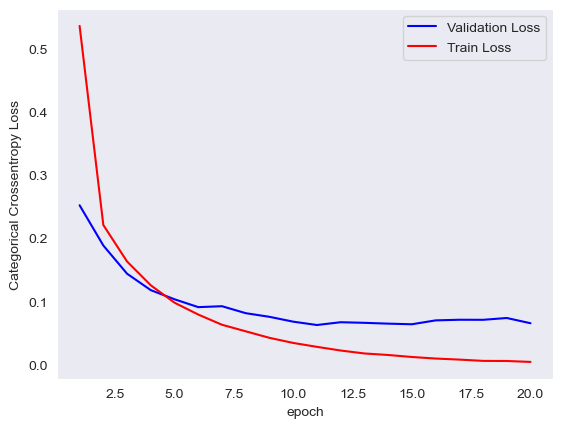

In [55]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [58]:
history.history


{'loss': [0.536008894443512,
  0.2206624299287796,
  0.16288501024246216,
  0.12520915269851685,
  0.0976659283041954,
  0.07889127731323242,
  0.06272197514772415,
  0.05234725400805473,
  0.04201268404722214,
  0.033944159746170044,
  0.02773195132613182,
  0.021942248567938805,
  0.017257627099752426,
  0.014865805394947529,
  0.01167962048202753,
  0.009220372885465622,
  0.007555773947387934,
  0.005513783078640699,
  0.0053422581404447556,
  0.0038732746616005898],
 'accuracy': [0.8590999841690063,
  0.935783326625824,
  0.9518833160400391,
  0.9627000093460083,
  0.9713166952133179,
  0.9767500162124634,
  0.9819166660308838,
  0.9843000173568726,
  0.987583339214325,
  0.9906499981880188,
  0.9927166700363159,
  0.9939666390419006,
  0.9958666563034058,
  0.9964500069618225,
  0.9974499940872192,
  0.9978333115577698,
  0.9984666705131531,
  0.9989166855812073,
  0.9988833069801331,
  0.9991999864578247],
 'val_loss': [0.2519557774066925,
  0.18823973834514618,
  0.143573150038